# Autoencoder

In this last practical session, we will train an autoencoder to extract a feature representation from an hyperspectral image. Our final goal is to use the encoder part of the autoencoder to extract a feature representation of our data and train any supervised model.

## Downloading the data

The data has been extracted from [Data Fusion Contest (DFC) 2018](https://site.ieee.org/france-grss/2018/01/16/data-fusion-contest-2018-contest-open/). They have been reprocessed to fit the learning objective of this practical session.

The proposed dataset is composed of
1. one hyperspectral image (1 m resolution), which is composed of 50 channels; and
2. a sparse ground truth label, which describes 20 classes:  
  (0 – Unclassified == unlabeled data)  
  1 – Healthy grass  
  2 – Stressed grass  
  3 – Artificial turf  
  4 – Evergreen trees  
  5 – Deciduous trees  
  6 – Bare earth  
  7 – Water  
  8 – Residential buildings  
  9 – Non-residential buildings  
  10 – Roads  
  11 – Sidewalks  
  12 – Crosswalks  
  13 – Major thoroughfares  
  14 – Highways  
  15 – Railways  
  16 – Paved parking lots  
  17 – Unpaved parking lots  
  18 – Cars  
  19 – Trains  
  20 – Stadium seats

  Both images contains 601 $\times$ 2384 pixels and are GeoTiff images. They cover the University of Houston campus and its surrounding areas.  


In [40]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [41]:
# #-- You need to change the path to your data path
# data_path = "/content/drive/MyDrive/MasterCDE/DeepLearning/autoencoder/"
data_path = "C:\\Users\\rufai\\Downloads\\Autoencoder"

In [42]:
#-- Uncomment this line if rasterio is not recognised
#!pip install rasterio

In [43]:
import rasterio
hsi_data = rasterio.open(data_path+"/DFC2018_20170218_HSI.tif")
gt_labels = rasterio.open(data_path+"/DFC2018_GT.tif")

In [44]:
#-- Look at the data
n_bands = hsi_data.count
print("HSI image size: ", hsi_data.shape)
print("HSI no. bands:", n_bands)
print("GT image size: ", gt_labels.shape)


HSI image size:  (601, 2384)
HSI no. bands: 50
GT image size:  (601, 2384)


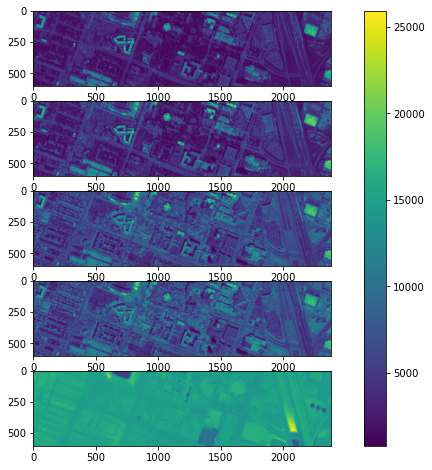

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,1,figsize=(12,8))
im1 = ax[0].imshow(hsi_data.read(10))
im2 = ax[1].imshow(hsi_data.read(20))
im3 = ax[2].imshow(hsi_data.read(30))
im4 = ax[3].imshow(hsi_data.read(40))
im5 = ax[4].imshow(hsi_data.read(50))
fig.colorbar(im1, ax=ax)

In [46]:
import matplotlib
from matplotlib import colors

# get color map from predefined palette
custom_ramp = matplotlib.cm.get_cmap('tab20')

# convert to hexcode
c_list=['#ffffff']

for i in range(custom_ramp.N):
    rgba = custom_ramp(i)
    # rgb2hex accepts rgb or rgba
    c_list.append(matplotlib.colors.rgb2hex(rgba))

In [47]:
#-- Label names
labels = ['unclassified','healthy grass','stressed grass', 'artificial turf', 'evergreen trees',
          'deciduous trees', 'bare earth', 'water', 'res buildings', 'non-res buildings',
          'roads','sidewalks', 'crosswalks', 'major thoroughfares', 'highways',
          'railways', 'paved parking', 'unpaved parking', 'cars', 'trains', 'stadium seats']

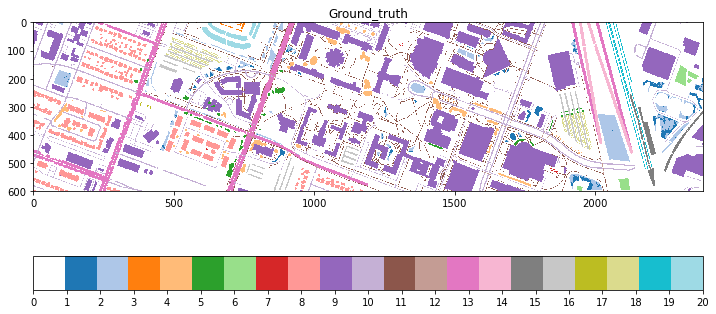

In [48]:
# visualize the ground truth labels
plt.figure(figsize=(12,8))
plt.imshow(gt_labels.read(1), interpolation='none', cmap=colors.ListedColormap(c_list))
plt.title("Ground_truth")
plt.colorbar(orientation="horizontal",  ticks=range(21))

In [49]:
#-- Computing the number of labels in the image
ind_gt = np.where(gt_labels.read(1)!=0) #-- get the indexes of the labeled data
print("Percentage of labeled pixels: ", len(ind_gt[0])/(gt_labels.shape[0]*gt_labels.shape[1])*100)

Percentage of labeled pixels:  35.225965672425154


## Autoencoder

From the previous experiments, we note that about 65 % of the data is unlabelled. If we train a supervised model, we will not benefit from this unlabelled data. The goal of this lab sesstion is thus to use an autoencoder to extract a better feature representation. 

In the following, we will consider that each pixel is one sample. We will thus not use the spatial information as we make the assumption that the spectral information is the most important. (Obviously more complex architectures that takes advantage of both spectral and spatial structure of the data can lead to an increase in the final classification performance.)


Let us first define our autoencoder model.

In [50]:
class MyAutoencoder(nn.Module):
    def __init__(self, n_bands=50):
        super(MyAutoencoder, self).__init__()
        #-- encoding layers
        self.enc1 = nn.Linear(n_bands, 40)
        self.enc2 = nn.Linear(40,30)
        self.enc3 = nn.Linear(30,20)
        self.enc4 = nn.Linear(20,10) #-- bottleneck layer
        
        #-- decoding layers
        self.dec1 = nn.Linear(10, 20)
        self.dec2 = nn.Linear(20,30)
        self.dec3 = nn.Linear(30,40)
        self.dec4 = nn.Linear(40,n_bands)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        out = torch.sigmoid(self.dec4(x)) #-- output in the range [0-1]
             
        return out

We will now preprocess the data, and then start the training of the autoencoder model.

In [51]:
#-- Min-max normalization
hsi_data_np = np.float32(hsi_data.read()).transpose(1,2,0)
X = ToTensor()(hsi_data_np) # HxWxC to CxHxW
minX = torch.amin(X, dim=(1,2)).unsqueeze(1).unsqueeze(1)
maxX = torch.amax(X, dim=(1,2)).unsqueeze(1).unsqueeze(1)
X = (X-minX)/(maxX-minX)

In [52]:
X.shape

torch.Size([50, 601, 2384])

In [53]:
X = X.flatten(start_dim=1) #--flatten as we do not consider the spatial structure of the data
print(X.shape)
X  = X.transpose(1,0) #-- MLP-based architecture (needs to be commented for 1D-CNN-based architecture)
print(X.shape)

torch.Size([50, 1432784])
torch.Size([1432784, 50])


We split here the data into train and validation sets. We do not create a test set as we are only interested in the downstream classification task.

In [54]:
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
X_train, X_val = random_split(X, [train_size, val_size])
print(X_train)
print("Training set size: ", X_train.dataset.shape)
print("Validation set size: ", X_val.dataset.shape)

Training set size:  torch.Size([1432784, 50])
Validation set size:  torch.Size([1432784, 50])


In [55]:
batch_size = 256
train_dataset_loader = DataLoader(dataset=X_train, batch_size=batch_size)
val_dataset_loader = DataLoader(dataset=X_val, batch_size=batch_size)

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [57]:
# Loss function
def loss_func(y_hat, y):
    return nn.MSELoss()(y_hat, y)

In [20]:
#-- Autoencoder training
train_loss = [] # where we keep track of the training loss
val_loss = [] # where we keep track of the validation loss
epochs = 5 # number of epochs

model = MyAutoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

for e in range(epochs):
  print("epoch: ", e)
  model.train()
  for x_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    x_hat = model(x_train_batch) # forward pass

    loss = loss_func(x_hat, x_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    train_loss.append(loss.item()/len(x_train_batch))
  
  model.eval()
  tmp_val_loss = 0
  with torch.no_grad():
    for x_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)    
      x_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(x_val_hat, x_val_batch).item() # compute the loss
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss   


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4


In [25]:
print(model)

MyAutoencoder(
  (enc1): Linear(in_features=50, out_features=40, bias=True)
  (enc2): Linear(in_features=40, out_features=30, bias=True)
  (enc3): Linear(in_features=30, out_features=20, bias=True)
  (enc4): Linear(in_features=20, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=20, bias=True)
  (dec2): Linear(in_features=20, out_features=30, bias=True)
  (dec3): Linear(in_features=30, out_features=40, bias=True)
  (dec4): Linear(in_features=40, out_features=50, bias=True)
)


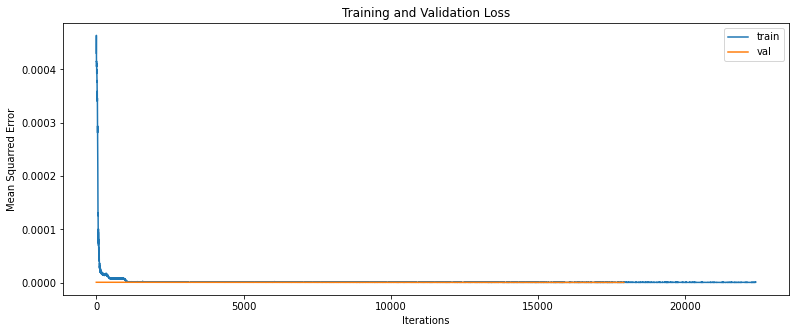

In [21]:
plt.figure(figsize=(13, 5))
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Mean Squarred Error')
plt.legend()

## Feature extraction

We will now extract the features learned in our bottleneck layer to use them to train a supervised learning model.

This requires the definition of a hook function, which is a command executed when a forward or backward call to a certain layer is performed. 

To extract features from a layer, we are interested in a simple forward hook that copies the layer outputs, sends them to CPU and saves them to a dictionary object we will call features.

In [22]:
# Hook definition
def get_features(name): #-- name specifies the dictionary key under which we will store our intermediate activations.
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

After the helper function is defined, we can register a hook using the `.register_forward_hook()` method. The hook can be applied to any layer of the neural network (here to the bottleneck layer).


In [23]:
model.enc4.register_forward_hook(get_features('feats'))

In [24]:
x_dataloader = DataLoader(dataset=X, batch_size=batch_size)
x_features = np.zeros((X.shape[0],10))
features = {}
ind_batch = 0
with torch.no_grad():
    for x_batch in x_dataloader:
      x_batch = x_batch.to(device)    
      x_hat = model(x_batch) # forward pass
      x_features[ind_batch*batch_size:(ind_batch+1)*batch_size] = features['feats'].cpu().numpy()
      ind_batch += 1

In [26]:
x_batch.shape
#.transpose(1, 2, 0)

torch.Size([208, 50])

In [27]:
x_train_batch

tensor([[0.0624, 0.0293, 0.0179,  ..., 0.2728, 0.0216, 0.5526],
        [0.2073, 0.1702, 0.1591,  ..., 0.3799, 0.0493, 0.5921],
        [0.1156, 0.0718, 0.0592,  ..., 0.2669, 0.6571, 0.5132],
        ...,
        [0.0903, 0.0681, 0.0544,  ..., 0.1500, 0.5038, 0.5921],
        [0.1103, 0.0583, 0.0394,  ..., 0.4008, 0.8672, 0.5263],
        [0.0744, 0.0359, 0.0231,  ..., 0.3481, 0.4411, 0.5921]],
       device='cuda:0')

## Classification task

In [28]:
#-- Extracting labeled data
X_label = x_features.reshape((hsi_data.shape[0], hsi_data.shape[1], x_features.shape[1]))
half_ind_r =  np.where(ind_gt[1]<hsi_data.shape[1]/2)[0] #-- split the data into two sets (right/left) to ensure data independency
half_ind_l =  np.where(ind_gt[1]>=hsi_data.shape[1]/2)[0]
X_train_label = X_label[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
y_train = gt_labels.read(1)[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
X_test_label = X_label[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]
y_test = gt_labels.read(1)[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_samples=100000, max_features='auto', max_depth=25, n_jobs=-1, random_state=0)
rf.fit(X_train_label, y_train)
y_pred = rf.predict(X_test_label)
print('Overall Accuracy: ', accuracy_score(y_test, y_pred))

Overall Accuracy:  0.4973604868394281


# Practical session

You will now try to improve this first results by changing the autoencoder architecture. To do so, you will use (1D) spectral convolutions instead of fully connected layers. For the decoder part, you can try to use max unpooling layers or transpose convolution layers.

If you have some time, you can also add some regularizations to implement a sparse autoencoder or a contractive autoencoder.

In [30]:
# FIRST AUTO ENCODER

class NewAutoencoder(nn.Module):
    def __init__(self, n_bands=50):
        super(NewAutoencoder, self).__init__()

        #-- ENCODER
        self.encoder = nn.Sequential(
            nn.Conv1d(n_bands, 40, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(40, 30, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(30,20, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(20,10, kernel_size=3, padding=2),
            nn.ReLU()
        )
        
        # BOTTLENECK LAYER
        self.bottle = nn.Conv1d(10, 5, kernel_size=3, padding=2)

        #-- DECODER
        self.decoder = nn.Sequential(
            nn.Conv1d(5, 10, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(10,20, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(20,30, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(30,40, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(40,n_bands, kernel_size=3, padding=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.bottle(x))
        out = torch.sigmoid(self.decoder(x)) #-- output in the range [0-1]

        return out

In [31]:
#-- Autoencoder training
train_loss = [] # where we keep track of the training loss
val_loss = [] # where we keep track of the validation loss
epochs = 5 # number of epochs

model = NewAutoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

for e in range(epochs):
  print("epoch: ", e)
  model.train()
  for x_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    x_hat = model(x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # forward pass

    loss = loss_func(x_hat, x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    train_loss.append(loss.item()/len(x_train_batch))
  
  model.eval()
  tmp_val_loss = 0
  with torch.no_grad():
    for x_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)    
      x_val_hat = model(x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)) # forward pass
      tmp_val_loss += loss_func(x_val_hat, x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)).item() # compute the loss
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss

epoch:  0


C:\Users\rufai\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([256, 50, 1])) that is different to the input size (torch.Size([256, 50, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\rufai\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([115, 50, 1])) that is different to the input size (torch.Size([115, 50, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  1
epoch:  2
epoch:  3
epoch:  4


In [58]:
print(model)

NewAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(50, 40, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(40, 30, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(30, 20, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(20, 10, kernel_size=(3,), stride=(1,), padding=(2,))
    (7): ReLU()
  )
  (bottle): Conv1d(10, 5, kernel_size=(3,), stride=(1,), padding=(2,))
  (decoder): Sequential(
    (0): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(30, 40, kernel_size=(3,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(40, 50, kernel_size=(3,), stride=(1,), padding=(2,))
  )
)


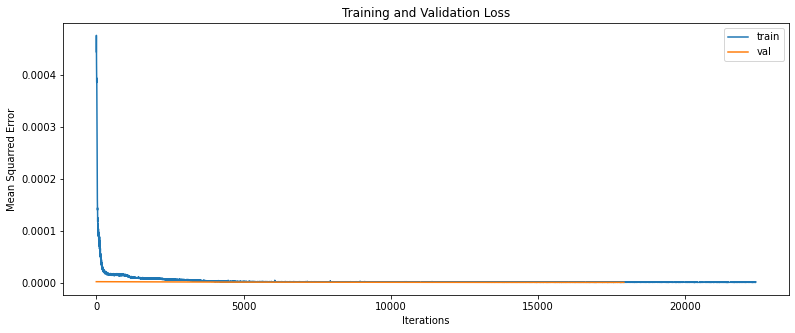

In [32]:
plt.figure(figsize=(13, 5))
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()

In [33]:
model.bottle.register_forward_hook(get_features('feats'))

In [34]:
g = torch.tensor(3)
g = g.long()

In [35]:
x_dataloader = DataLoader(dataset=X, batch_size=batch_size)
x_features = np.zeros((X.shape[0],5, 11))
features = {}
ind_batch = 0
with torch.no_grad():
    for x_batch in x_dataloader:
      x_batch = x_batch.reshape(x_batch.shape[0], x_batch.shape[1], 1)
      x_batch = x_batch.to(device)    
      x_hat = model(x_batch)  # forward pass # .view( x_batch[0].to(torch.int16), x_batch[1].to(torch.int16), g.to(torch.int16))

      x_features[ind_batch*batch_size:(ind_batch+1)*batch_size] = features['feats'].cpu().numpy()
      
      ind_batch += 1

In [36]:
x_features = x_features[:, :, :10]

In [37]:
#-- Extracting labeled data
X_label = x_features.reshape((hsi_data.shape[0], hsi_data.shape[1], 50))
half_ind_r =  np.where(ind_gt[1]<hsi_data.shape[1]/2)[0] #-- split the data into two sets (right/left) to ensure data independency
half_ind_l =  np.where(ind_gt[1]>=hsi_data.shape[1]/2)[0]
X_train_label = X_label[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
y_train = gt_labels.read(1)[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
X_test_label = X_label[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]
y_test = gt_labels.read(1)[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]

In [38]:
batch_size = 256
train_dataset_loader = DataLoader(dataset=X_train, batch_size=batch_size)
val_dataset_loader = DataLoader(dataset=X_val, batch_size=batch_size)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_samples=100000, max_features='auto', max_depth=25, n_jobs=-1, random_state=0)
rf.fit(X_train_label, y_train)
y_pred = rf.predict(X_test_label)
print('Overall Accuracy: ', accuracy_score(y_test, y_pred))

Overall Accuracy:  0.4178310489613969


#### Second Auto encoder

In [59]:
# SECOND AUTO ENCODER

class SecondAutoencoder(nn.Module):
    def __init__(self, n_bands=50):
        super(SecondAutoencoder, self).__init__()

        #-- ENCODER
        self.encoder = nn.Sequential(
            nn.Conv1d(n_bands, 40, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(40, 30, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(30,20, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(20,10, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(10, 5, kernel_size=3, padding=2),
            nn.ReLU()
        )
        
        # BOTTLENECK LAYER
        self.bottle = nn.Conv1d(5, 1, kernel_size=3, padding=2)

        #-- DECODER
        self.decoder = nn.Sequential(
            nn.Conv1d(1, 5, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(5, 10, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(10,20, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(20,30, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(30,40, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv1d(40,n_bands, kernel_size=3, padding=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.bottle(x))
        out = torch.sigmoid(self.decoder(x)) #-- output in the range [0-1]

        return out

In [60]:
#-- Autoencoder training
train_loss = [] # where we keep track of the training loss
val_loss = [] # where we keep track of the validation loss
epochs = 5 # number of epochs

model = SecondAutoencoder()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

for e in range(epochs):
  print("epoch: ", e)
  model.train()
  for x_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    x_hat = model(x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # forward pass

    loss = loss_func(x_hat, x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    train_loss.append(loss.item()/len(x_train_batch))
  
  model.eval()
  tmp_val_loss = 0
  with torch.no_grad():
    for x_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)    
      x_val_hat = model(x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)) # forward pass
      tmp_val_loss += loss_func(x_val_hat, x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)).item() # compute the loss
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss

epoch:  0


C:\Users\rufai\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([256, 50, 1])) that is different to the input size (torch.Size([256, 50, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\rufai\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([115, 50, 1])) that is different to the input size (torch.Size([115, 50, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:  1
epoch:  2
epoch:  3
epoch:  4


In [61]:
print(model)

SecondAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(50, 40, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(40, 30, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(30, 20, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(20, 10, kernel_size=(3,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(10, 5, kernel_size=(3,), stride=(1,), padding=(2,))
    (9): ReLU()
  )
  (bottle): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=(2,))
  (decoder): Sequential(
    (0): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(30, 40, kernel_size=(3,), stride=(1,), padding=(2,))
    (9): ReLU()
    (10): C

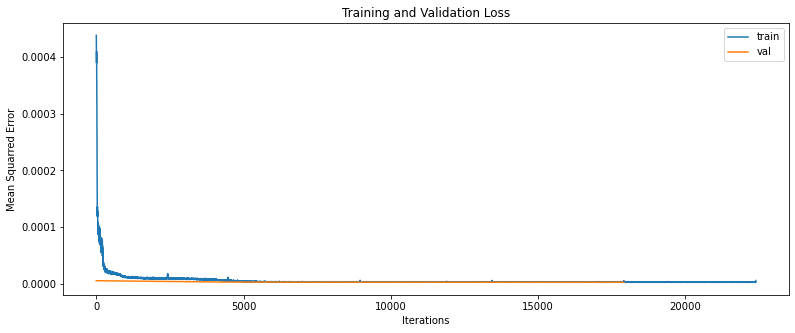

In [62]:
plt.figure(figsize=(13, 5))
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Mean Squarred Error')
plt.legend()

In [63]:
model.bottle.register_forward_hook(get_features('feats'))

In [70]:
x_dataloader = DataLoader(dataset=X, batch_size=batch_size)
x_features = np.zeros((X.shape[0],5, 13))
features = {}
ind_batch = 0
with torch.no_grad():
    for x_batch in x_dataloader:
      x_batch = x_batch.reshape(x_batch.shape[0], x_batch.shape[1], 1)
      x_batch = x_batch.to(device)    
      x_hat = model(x_batch)  # forward pass # .view( x_batch[0].to(torch.int16), x_batch[1].to(torch.int16), g.to(torch.int16))

      x_features[ind_batch*batch_size:(ind_batch+1)*batch_size] = features['feats'].cpu().numpy()
      
      ind_batch += 1

In [66]:
x_features = x_features[:, :, :13]

In [72]:
#-- Extracting labeled data
X_label = x_features.reshape((hsi_data.shape[0], hsi_data.shape[1], 65))
half_ind_r =  np.where(ind_gt[1]<hsi_data.shape[1]/2)[0] #-- split the data into two sets (right/left) to ensure data independency
half_ind_l =  np.where(ind_gt[1]>=hsi_data.shape[1]/2)[0]
X_train_label = X_label[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
y_train = gt_labels.read(1)[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
X_test_label = X_label[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]
y_test = gt_labels.read(1)[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]

In [73]:
batch_size = 256
train_dataset_loader = DataLoader(dataset=X_train, batch_size=batch_size)
val_dataset_loader = DataLoader(dataset=X_val, batch_size=batch_size)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_samples=100000, max_features='auto', max_depth=25, n_jobs=-1, random_state=0)
rf.fit(X_train_label, y_train)
y_pred = rf.predict(X_test_label)
print('Overall Accuracy: ', accuracy_score(y_test, y_pred))

Overall Accuracy:  0.4278008989512236


### Sparse Autoencoder

In [77]:
from torch.autograd import Function

class L1Penalty(Function):

    @staticmethod
    def forward(ctx, input, l1weight):
        ctx.save_for_backward(input)
        ctx.l1weight = l1weight
        return input

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_variables
        grad_input = input.clone().sign().mul(self.l1weight)
        grad_input += grad_output
        return grad_input

In [83]:
class SparseAutoEncoder(torch.nn.Module):
  def __init__(self, l1weight, n_bands=50):
    super(SparseAutoEncoder, self).__init__()

    # ENCODER
    self.s_enc1 = nn.Linear(n_bands, 40)
    self.s_enc2 = nn.Linear(40,30)
    self.s_enc3 = nn.Linear(30,20)
    self.bottle = nn.Linear(20,10) #-- BOTTLENECK LAYER

    # DECODER
    self.s_dec1 = nn.Linear(10, 20)
    self.s_dec2 = nn.Linear(20,30)
    self.s_dec3 = nn.Linear(30,40)
    self.s_dec4 = nn.Linear(40, n_bands)

    # PROPERTIES
    self.feature_size = n_bands
    self.l1weight = l1weight
    
    
  def forward(self, x):
      x = F.relu(self.s_enc1(x))
      x = F.relu(self.s_enc2(x))
      x = F.relu(self.s_enc3(x))
      x = F.relu(self.bottle(x))
      
      # SPARSITY PENALTY
      x = L1Penalty.apply(x, self.l1weight)
    
      x = F.relu(self.s_dec1(x))
      x = F.relu(self.s_dec2(x))
      x = F.relu(self.s_dec3(x))
      out = torch.sigmoid(self.s_dec4(x)) #-- output in the range [0-1]
      
      return out.view_as(input)


In [84]:
#-- Autoencoder training
train_loss = [] # where we keep track of the training loss
val_loss = [] # where we keep track of the validation loss
epochs = 5 # number of epochs

model = SparseAutoEncoder(3)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

for e in range(epochs):
  print("epoch: ", e)
  model.train()
  for x_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    x_hat = model(x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # forward pass

    loss = loss_func(x_hat, x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    train_loss.append(loss.item()/len(x_train_batch))
  
  model.eval()
  tmp_val_loss = 0
  with torch.no_grad():
    for x_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)    
      x_val_hat = model(x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)) # forward pass
      tmp_val_loss += loss_func(x_val_hat, x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)).item() # compute the loss
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss

epoch:  0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (12800x1 and 50x40)

In [ ]:
plt.figure(figsize=(13, 5))
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Mean Squarred Error')
plt.legend()

In [ ]:
model.bottle.register_forward_hook(get_features('feats'))

In [ ]:
x_dataloader = DataLoader(dataset=X, batch_size=batch_size)
x_features = np.zeros((X.shape[0],5, 13))
features = {}
ind_batch = 0
with torch.no_grad():
    for x_batch in x_dataloader:
      x_batch = x_batch.reshape(x_batch.shape[0], x_batch.shape[1], 1)
      x_batch = x_batch.to(device)    
      x_hat = model(x_batch)  # forward pass # .view( x_batch[0].to(torch.int16), x_batch[1].to(torch.int16), g.to(torch.int16))

      x_features[ind_batch*batch_size:(ind_batch+1)*batch_size] = features['feats'].cpu().numpy()
      
      ind_batch += 1

In [ ]:
#-- Extracting labeled data
X_label = x_features.reshape((hsi_data.shape[0], hsi_data.shape[1], 65))
half_ind_r =  np.where(ind_gt[1]<hsi_data.shape[1]/2)[0] #-- split the data into two sets (right/left) to ensure data independency
half_ind_l =  np.where(ind_gt[1]>=hsi_data.shape[1]/2)[0]
X_train_label = X_label[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
y_train = gt_labels.read(1)[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
X_test_label = X_label[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]
y_test = gt_labels.read(1)[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]

In [ ]:
batch_size = 256
train_dataset_loader = DataLoader(dataset=X_train, batch_size=batch_size)
val_dataset_loader = DataLoader(dataset=X_val, batch_size=batch_size)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_samples=100000, max_features='auto', max_depth=25, n_jobs=-1, random_state=0)
rf.fit(X_train_label, y_train)
y_pred = rf.predict(X_test_label)
print('Overall Accuracy: ', accuracy_score(y_test, y_pred))

### Contractive Autoencoder

In [ ]:
# COMPUTE THE CONTRACTIVE AUTOENCODER LOSS


In [ ]:
class ContractiveAutoEncoder(torch.nn.Module):
  def __init__(self, l1weight, n_bands=50):
    super(ContractiveAutoEncoder, self).__init__()

    # ENCODER
    self.s_enc1 = nn.Linear(n_bands, 40)
    self.s_enc2 = nn.Linear(40,30)
    self.s_enc3 = nn.Linear(30,20)
    self.bottle = nn.Linear(20,10) #-- BOTTLENECK LAYER

    # DECODER
    self.s_dec1 = nn.Linear(10, 20)
    self.s_dec2 = nn.Linear(20,30)
    self.s_dec3 = nn.Linear(30,40)
    self.s_dec4 = nn.Linear(40, n_bands)

    # PROPERTIES
    self.feature_size = n_bands
    self.l1weight = l1weight
    
    
  def forward(self, x):
      x = F.relu(self.s_enc1(x))
      x = F.relu(self.s_enc2(x))
      x = F.relu(self.s_enc3(x))
      x = F.relu(self.s_enc4(x))
      
      # SPARSITY PENALTY
      x = L1Penalty.apply(x, self.l1weight)
    
      x = F.relu(self.s_dec1(x))
      x = F.relu(self.s_dec2(x))
      x = F.relu(self.s_dec3(x))
      out = torch.sigmoid(self.s_dec4(x)) #-- output in the range [0-1]
      
      return out.view_as(input)

In [ ]:
#-- Autoencoder training
train_loss = [] # where we keep track of the training loss
val_loss = [] # where we keep track of the validation loss
epochs = 5 # number of epochs

model = SparseAutoEncoder(3)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=.001)

for e in range(epochs):
  print("epoch: ", e)
  model.train()
  for x_train_batch in train_dataset_loader:
    x_train_batch = x_train_batch.to(device)
    x_hat = model(x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # forward pass

    loss = loss_func(x_hat, x_train_batch.reshape(x_train_batch.shape[0], x_train_batch.shape[1], 1)) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    train_loss.append(loss.item()/len(x_train_batch))
  
  model.eval()
  tmp_val_loss = 0
  with torch.no_grad():
    for x_val_batch in val_dataset_loader:
      x_val_batch = x_train_batch.to(device)    
      x_val_hat = model(x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)) # forward pass
      tmp_val_loss += loss_func(x_val_hat, x_val_batch.reshape(x_val_batch.shape[0], x_val_batch.shape[1], 1)).item() # compute the loss
  val_loss.append(tmp_val_loss/len(val_dataset_loader.dataset)) # compute the average loss

In [ ]:
plt.figure(figsize=(13, 5))
plt.title('Training and Validation Loss')
plt.plot(list(range(epochs*len(train_dataset_loader))),train_loss, label="train")
plt.plot(list(range(0, epochs*len(train_dataset_loader),len(train_dataset_loader))), val_loss, label="val")
plt.xlabel('Iterations')
plt.ylabel('Mean Squarred Error')
plt.legend()

In [ ]:
model.bottle.register_forward_hook(get_features('feats'))

In [ ]:
x_dataloader = DataLoader(dataset=X, batch_size=batch_size)
x_features = np.zeros((X.shape[0],5, 13))
features = {}
ind_batch = 0
with torch.no_grad():
    for x_batch in x_dataloader:
      x_batch = x_batch.reshape(x_batch.shape[0], x_batch.shape[1], 1)
      x_batch = x_batch.to(device)    
      x_hat = model(x_batch)  # forward pass # .view( x_batch[0].to(torch.int16), x_batch[1].to(torch.int16), g.to(torch.int16))

      x_features[ind_batch*batch_size:(ind_batch+1)*batch_size] = features['feats'].cpu().numpy()
      
      ind_batch += 1

In [ ]:
#-- Extracting labeled data
X_label = x_features.reshape((hsi_data.shape[0], hsi_data.shape[1], 65))
half_ind_r =  np.where(ind_gt[1]<hsi_data.shape[1]/2)[0] #-- split the data into two sets (right/left) to ensure data independency
half_ind_l =  np.where(ind_gt[1]>=hsi_data.shape[1]/2)[0]
X_train_label = X_label[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
y_train = gt_labels.read(1)[ind_gt[0][half_ind_r], ind_gt[1][half_ind_r]]
X_test_label = X_label[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]
y_test = gt_labels.read(1)[ind_gt[0][half_ind_l], ind_gt[1][half_ind_l]]

In [ ]:
batch_size = 256
train_dataset_loader = DataLoader(dataset=X_train, batch_size=batch_size)
val_dataset_loader = DataLoader(dataset=X_val, batch_size=batch_size)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_samples=100000, max_features='auto', max_depth=25, n_jobs=-1, random_state=0)
rf.fit(X_train_label, y_train)
y_pred = rf.predict(X_test_label)
print('Overall Accuracy: ', accuracy_score(y_test, y_pred))